# Iris dataset - Classificação com mais de uma camada

Este notebook reproduz o exemplo anterior de Regressão Logística, porém durante o treinamento, podemos acompanhar os gráficos de perda e fronteiras de decisão.

In [49]:
%matplotlib inline
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn


## Leitura, normalização e visualização dos dados

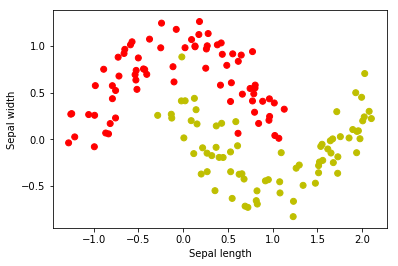

In [128]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = 'moon'
if option is 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option is 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option is 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option is 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

## Prepara os dados para o PyTorch

In [129]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [137]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 3),
        )
    
    def forward(self, x):
        x = self.dense(x)
        
        return x
    
model = Modelo()
print(model)

Modelo (
  (dense): Sequential (
    (0): Linear (2 -> 50)
    (1): ReLU ()
    (2): Linear (50 -> 3)
  )
)


## Parâmetros para o treinamento

In [138]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

## Classe para visualização dinâmica

In [139]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)
    
    return predicts.data.numpy()

class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]
        
        
    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])
            
            if epoch%250==0:
                
                plt.subplot(121)
                plt.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)
                
                plt.subplot(122)
                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Z = Z.reshape(self.xx.shape)
                
                plt.figure(1, figsize=(4, 3))
                plt.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                
                colors = np.array(['r','y','b'])
                plt.scatter(self.X[:, 0], self.X[:, 1], s=400, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)
                
                display.display(plt.gcf())
                display.clear_output(wait=True)

## Laço principal de treinamento da Regressão Logística por Softmax

Final loss: 0.043210119009017944


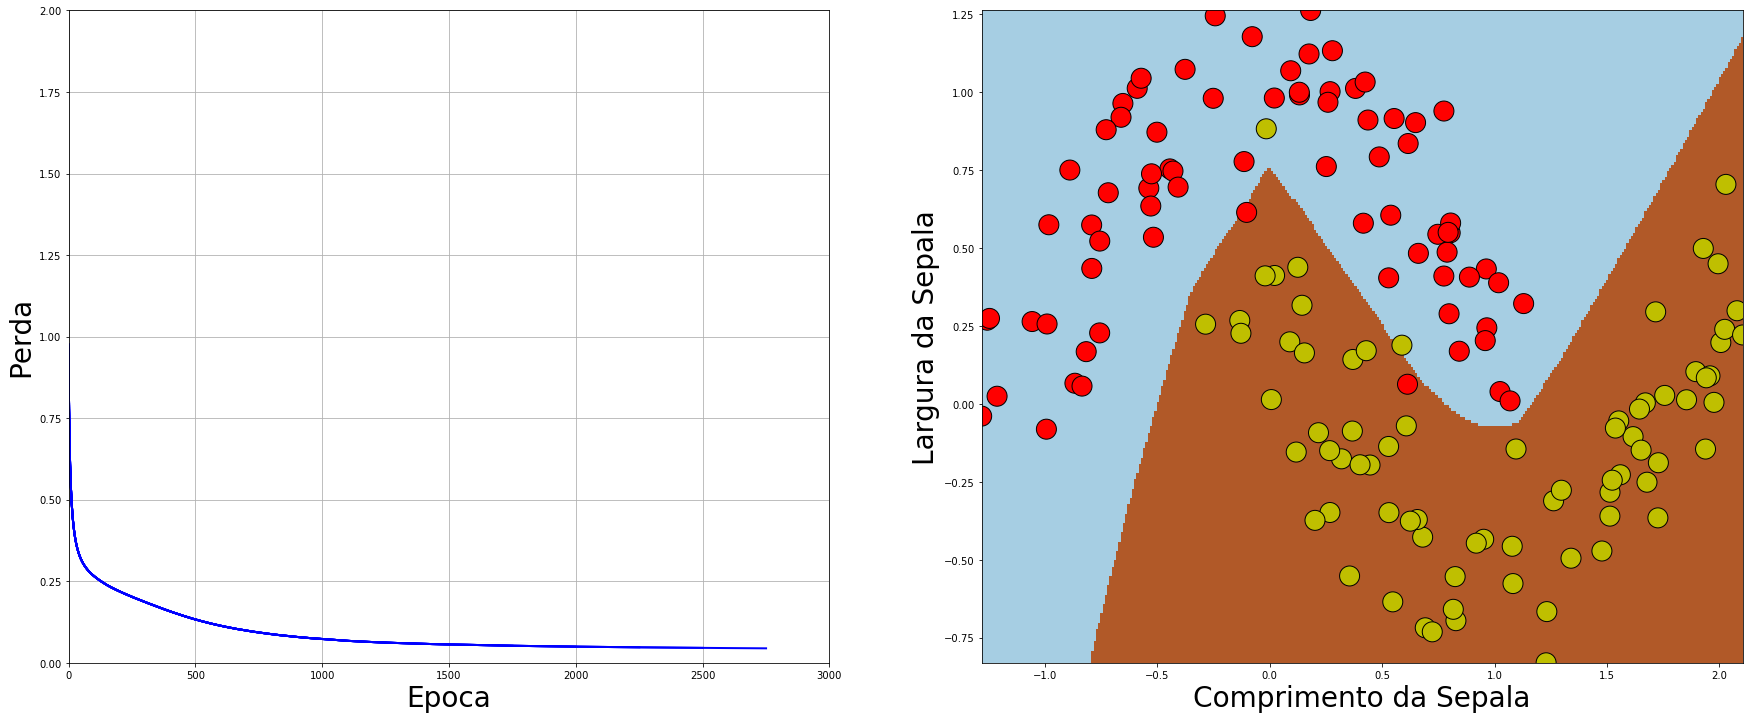

In [140]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

#Gráficos a serem mostrados pelo callback
ploss = 2.0
fig = plt.figure(figsize=(30,12))
plt.subplot(121)
#plt.plot(0.0,ploss)
plt.ylim(0.0, ploss)
plt.xlim(0, nb_epoch)
plt.xlabel('Epoca',fontsize=28)
plt.ylabel('Perda',fontsize=28)
plt.plot(-1,-1,'b',linewidth = 2.0,label = "Treino")
plt.grid(True)

plt.subplot(122)
plt.xlim(Xc[:,0].min(), Xc[:,0].max())
plt.ylim(Xc[:,1].min(), Xc[:,1].max())
plt.xlabel('Comprimento da Sepala',fontsize=28)
plt.ylabel('Largura da Sepala',fontsize=28)

n = Xc.shape[0] # number of training examples


losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.data[0])
    
    boundary_plot.on_epoch_end(i, {'loss': loss.data[0]})
    
print('Final loss:', loss.data[0])

## Imprimindo pesos finais

In [141]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    #print(w)

dense.0.weight  torch.Size([50, 2])
dense.0.bias    torch.Size([50])
dense.2.weight  torch.Size([3, 50])
dense.2.bias    torch.Size([3])


## Avaliação do classificador

In [136]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print() 
print('Training Accuracy: ', accuracy)

print('Matriz de confusão:')
import pandas as pd
pd.crosstab(Y_hat, Y)


Training Accuracy:  1.0
Matriz de confusão:


col_0,0,1
row_0,,
0,75,0
1,0,75


## Atividades

### Experimentos:

1. Troque o dataset, utilizado. Veja que tem vários para escolher.
3. Faça alterações na rede, alterando o número de neurônios, de camadas. 
4. O que ocorre quando não se utiliza ativação não linear entre camadas.

## Principais aprendizados